# Laboratorium

### Konfiguracja

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15


def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))


# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax

    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling=True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling=True)

    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))

    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()

    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []

    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling=False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling=False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling=False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (
                        np.mean([self.ax.get_xlim(), self.ax.get_ylim()]) * TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling=False)

    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling=True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [3]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=None, lines=None):
        self.points = points or []
        self.lines = lines or []


# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs

    def add_points(self, points):
        self.points = self.points + points


# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs

    def add(self, line):
        self.lines.append(line)

    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)


# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes=[Scene()], points=[], lines=[], json=None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]],
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]])
                           for scene in js.loads(json)]

    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]

    def add_scene(self, scene):
        self.scenes.append(scene)

    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points],
                          "lines": [linesCol.lines for linesCol in scene.lines]}
                         for scene in self.scenes])

        # Metoda ta zwraca punkty dodane w trakcie rysowania.

    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None

    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None

    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None

    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines + self.callback.added_rects)
        else:
            return None

    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on=False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()


In [63]:
#Config
zero_distance_tolerance = np.float64(1e-4)

In [64]:
# 'needed' globals
datasets_names = ('1a', '1b', '1c', '1d')
classifications = {
    'AA': 'macierz 3x3 własny wyznacznik',
    'AB': 'macierz 2x2 własny wyznacznik',
    'BA': 'macierz 3x3 wyznacznik numpy',
    'BB': 'macierz 2x2 wyznacznik numpy'
}
comparisons = [('AA', 'AB'), ('AA', 'BA'), ('AA', 'BB'), ('BA', 'AB'), ('BB', 'BA'), ('BB', 'AB')]
points_classifications = {dataset_name: list() for dataset_name in datasets_names}
datasets_points = {dataset_name: list() for dataset_name in datasets_names}
a = (np.float64(-1.0), np.float64(0.0))
b = (np.float64(1.0), np.float64(0.1))
classification_vector = (a, b)


In [65]:
# 1a) 10**5 points which coordinates are in range [-1000; 1000]

import random as rd

mini_x = -1000.0
maxi_x = 1000.0
mini_y = -1000.0
maxi_y = 1000.0

no_of_points = 10 ** 5
# no_of_points = 5


# points_xs = np.random.uniform(mini_x, maxi_x, no_of_points) # maxi_x is excluded
# points_ys = np.random.uniform(mini_y, maxi_y, no_of_points) # maxi_y is excluded
# datasets_points['1a'] = [(x, y) for x, y in zip(points_xs, points_ys)]

p1a_x = [(np.float64(rd.uniform(mini_x, maxi_x))) for _ in range(no_of_points)]
p1a_y = [(np.float64(rd.uniform(mini_y, maxi_y))) for _ in range(no_of_points)]
datasets_points['1a'] = [(x, y) for x, y in zip(p1a_x, p1a_y)]


In [66]:
# 1b) 10**5 points which coordinates are in range [-10**14; 10**14]

import random as rd

mini_x = -10.0 ** 14
maxi_x = 10.0 ** 14
mini_y = -10.0 ** 14
maxi_y = 10.0 ** 14

no_of_points = 10 ** 5
# no_of_points = 5

p1b_x = [(np.float64(rd.uniform(mini_x, maxi_x))) for _ in range(no_of_points)]
p1b_y = [(np.float64(rd.uniform(mini_y, maxi_y))) for _ in range(no_of_points)]
datasets_points['1b'] = [(x, y) for x, y in zip(p1b_x, p1b_y)]

In [67]:
# 1c) 1000 points such that        x**2 + y**2 == 100**2

radius = 100

no_of_points = 1000
# no_of_points = 10

# point = (cos(2*pi*t), sin(2*pi*t))
p1c_t = np.random.uniform(0, 1, no_of_points)
p1c_x = np.cos(p1c_t * 2 * np.pi)
p1c_y = np.sin(p1c_t * 2 * np.pi)
datasets_points['1c'] = [(x, y) for x, y in zip(p1c_x, p1c_y)]

In [68]:
# 1d) 1000 points which coordinates are in range [-1000; 1000] and the points lie on the line defined by the vector (a, b)

mini_x = -1000.0
maxi_x = 1000.0
mini_y = -1000.0
maxi_y = 1000.0

a = (np.float64(-1.0), np.float64(0.0))
b = (np.float64(1.0), np.float64(0.1))

no_of_points = 1000
# no_of_points = 10

# (y−yA)(xB−xA)−(yB−yA)(x−xA)=0
# y = ((yB-yA)/(xB-xA))*(x-xA) + yA


if abs(a[0] - b[0]) < zero_distance_tolerance:  # same x
    p1d_y = [(np.float64(rd.uniform(mini_y, maxi_y))) for _ in range(no_of_points)]
    x1d = (a[0] + b[0]) / 2
    datasets_points['1d'] = [(x1d, y) for y in p1d_y]
else:
    while len(datasets_points['1d']) < no_of_points:
        x = np.float64(rd.uniform(mini_x, maxi_x))
        y = ((b[1] - a[1]) / (b[0] - a[0])) * (x - a[0]) + a[1]
        if mini_y <= y <= maxi_y:
            datasets_points['1d'].append((x, y))

### 2. Graphic visualization

In [ ]:
# 1a visualization - not very useful because of no of points

%matplotlib notebook

plot1a = Plot(points=[PointsCollection(datasets_points['1a'])])
plot1a.draw()

<IPython.core.display.Javascript object>

In [ ]:
# 1b visualization - not very useful because of no of points

%matplotlib notebook

plot1b = Plot(points=[PointsCollection(datasets_points['1b'])])
plot1b.draw()

In [ ]:
# 1c visualization

%matplotlib notebook

plot1c = Plot(points=[PointsCollection(datasets_points['1c'])])
plot1c.draw()

<IPython.core.display.Javascript object>


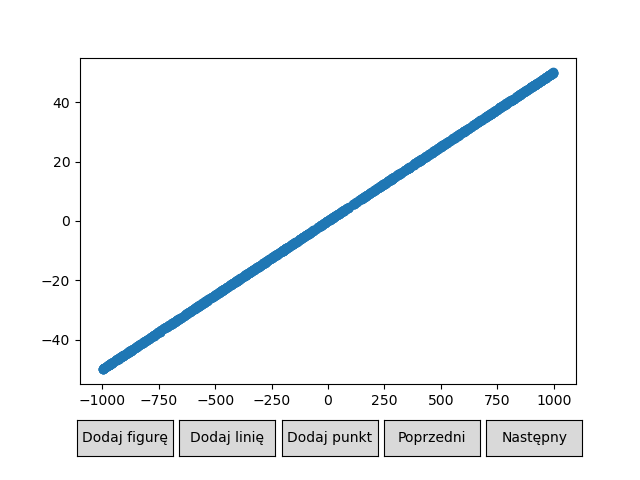

In [40]:
# 1d visualization

%matplotlib notebook

plot1d = Plot(points=[PointsCollection(datasets_points['1d'])])
plot1d.draw()

##### Zad.4

In [69]:
from typing import Iterable
from enum import Enum

# 4) functions



def calc_det(matrix):  # calculation of matrix det written for WDI
    def calc_det_recur(matrix, y, il, poss, perm, inv):
        if y >= len(matrix):
            nonlocal su

            if inv % 2 == 0:
                sign = 1
            else:
                sign = -1

            su += sign * il
            return il

        for curr_i in poss:
            inv_c = inv
            for perm_el in perm:
                if perm_el > curr_i:
                    inv_c += 1

            calc_det_recur(matrix, y + 1, il * matrix[y][curr_i], [i for i in poss if i != curr_i], perm + [curr_i],
                           inv_c)

    su = 0
    poss = [i for i in range(len(matrix))]
    for curr_i in range(len(matrix[0])):
        calc_det_recur(matrix, 1, matrix[0][curr_i], [i for i in poss if i != curr_i], [curr_i], 0)

    return su


def create_3x3_matrix(xC, yC, ab_vector: tuple):
    (xA, yA), (xB, yB) = ab_vector

    matrix = [
        [xA, yA, 1],
        [xB, yB, 1],
        [xC, yC, 1]
    ]

    return matrix


def create_2x2_matrix(xC, yC, ab_vector: tuple):
    (xA, yA), (xB, yB) = ab_vector

    matrix = [
        [xA - xC, yA - yC],
        [xB - xC, yB - yC]
    ]

    return matrix


class PointType(Enum):
    LEFT = 1
    COLLINEAR = 2
    RIGHT = 3


def classify_points(points_to_divide: list, ab_vector: tuple, matrix_creation_function, determinant_function):
    points_classification = dict()
    left_is = set()
    collinear_is = set()
    right_is = set()

    for i, pointC in enumerate(points_to_divide):
        xC, yC = pointC
        matrix = matrix_creation_function(xC, yC, ab_vector)
        det = determinant_function(matrix)

        if abs(det) < zero_distance_tolerance:
            collinear_is.add(i)
            points_classification[i] = PointType.COLLINEAR
        elif det < 0:
            left_is.add(i)
            points_classification[i] = PointType.LEFT
        else:
            right_is.add(i)
            points_classification[i] = PointType.RIGHT

    return points_classification

def divide_into_groups(these_points: Iterable, these_points_classification):
    dp_i = {
        PointType.RIGHT: list(),
        PointType.LEFT: list(),
        PointType.COLLINEAR: list(),
    }

    for i, point in enumerate(these_points):
        dp_i[these_points_classification[i]].append(i)


    return dp_i


In [70]:
points_classifications: dict[str: dict[str: list]] = {
    dataset_name: {
        'AA': classify_points(datasets_points[dataset_name], classification_vector, create_3x3_matrix, calc_det),
        'BA': classify_points(datasets_points[dataset_name], classification_vector, create_3x3_matrix, np.linalg.det),
        'AB': classify_points(datasets_points[dataset_name], classification_vector, create_2x2_matrix, calc_det),
        'BB': classify_points(datasets_points[dataset_name], classification_vector, create_2x2_matrix, np.linalg.det),
    }
    for dataset_name in datasets_names
}

In [71]:
from typing import Iterable


def compare_results(points: Iterable, classification1, classification2) -> set[int]:
    different_points = set()

    for pi in points:
        point_classification1 = classification1.get(pi)
        point_classification2 = classification2.get(pi)
        if point_classification1 != point_classification2:
            different_points.add(pi)

    return different_points

In [72]:
def compare_all_results() -> dict[str: dict]:
    differences = {dataset_name: dict() for dataset_name in datasets_names}

    for dataset_name in datasets_names:
        curr_points_ids = range(len(datasets_points.get(dataset_name)))


        differences[dataset_name]['AA-BA'] = compare_results(curr_points_ids, points_classifications[dataset_name]['AA'], points_classifications[dataset_name]['BA'])
        differences[dataset_name]['AA-AB'] = compare_results(curr_points_ids, points_classifications[dataset_name]['AA'], points_classifications[dataset_name]['AB'])
        differences[dataset_name]['AA-BB'] = compare_results(curr_points_ids, points_classifications[dataset_name]['AA'], points_classifications[dataset_name]['BB'])
        differences[dataset_name]['BA-AB'] = compare_results(curr_points_ids, points_classifications[dataset_name]['BA'], points_classifications[dataset_name]['AB'])
        differences[dataset_name]['BB-BA'] = compare_results(curr_points_ids, points_classifications[dataset_name]['BB'], points_classifications[dataset_name]['BA'])
        differences[dataset_name]['BB-AB'] = compare_results(curr_points_ids, points_classifications[dataset_name]['BB'], points_classifications[dataset_name]['AB'])

    return differences


all_differences: dict[str: dict] = compare_all_results()

In [73]:
# 4) save results to file

file_name = 'tolerance_' + str(zero_distance_tolerance) + '_results.csv'

dialect = 'excel'

import csv


def save_results_to_file():
    with open(file_name, newline='', mode='w') as csv_file:
        csv_writer = csv.writer(csv_file, dialect=dialect)

        csv_writer.writerow(['Epsilon', zero_distance_tolerance])
        csv_writer.writerow([])

        csv_writer.writerow(['Metoda klasyfikacji punktów'] + [f'dataset {dataset_name} - classification {point_type.name}'
                                                               for dataset_name in datasets_names
                                                               for point_type in [PointType.LEFT, PointType.COLLINEAR, PointType.RIGHT]])

        for code, description in classifications.items():
            row_data = []
            for dataset_name in datasets_names:
                divided_points_ids = divide_into_groups(datasets_points[dataset_name], points_classifications[dataset_name][code])
                row_data.append(len(divided_points_ids[PointType.LEFT]))
                row_data.append(len(divided_points_ids[PointType.COLLINEAR]))
                row_data.append(len(divided_points_ids[PointType.RIGHT]))

            csv_writer.writerow([description, ] + row_data)

        csv_writer.writerow([])
        csv_writer.writerow([])

        csv_writer.writerow(['Ilość różnych kwalifikacji punktów'])
        csv_writer.writerow(
            [f'metoda kwalifikacji {i}' for i in range(1, 2 + 1)] +
            [f'dataset {dataset_name}' for dataset_name in datasets_names])

        for code1, code2 in comparisons:
            if code1 == code2:
                continue

            results = [len(all_differences.get(dataset_name).get(f'{code1}-{code2}')) for dataset_name in datasets_names]

            csv_writer.writerow([classifications.get(code1), classifications.get(code2)] + results)

save_results_to_file()


<IPython.core.display.Javascript object>


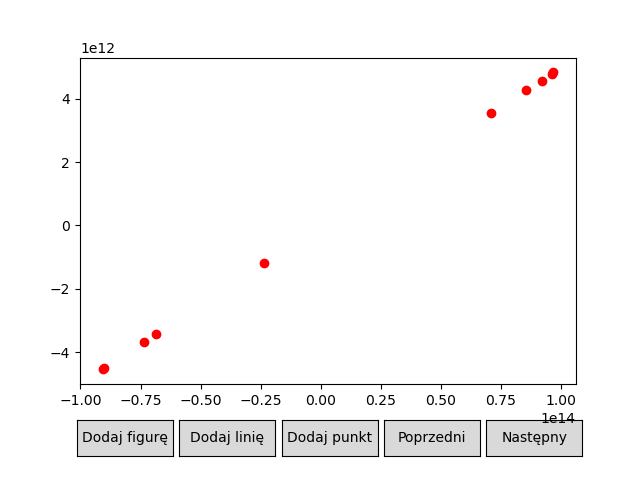

In [74]:
#

%matplotlib notebook

dataset_to_print_names = {
    '1a': [
        ('AA', 'AB'),
        ('AA', 'BA'),
        ('AA', 'BB'),
        ('BA', 'AB'),
        ('BB', 'AB'),
        ('BB', 'BA'),
    ],
    '1b': [
        ('AA', 'AB'),
        ('AA', 'BA'),
        ('AA', 'BB'),
        ('BA', 'AB'),
        ('BB', 'AB'),
        ('BB', 'BA'),
    ],
    '1c': [
        ('AA', 'AB'),
        ('AA', 'BA'),
        ('AA', 'BB'),
        ('BA', 'AB'),
        ('BB', 'AB'),
        ('BB', 'BA'),
    ],
    '1d': [
        ('AA', 'AB'),
        ('AA', 'BA'),
        ('AA', 'BB'),
        ('BA', 'AB'),
        ('BB', 'AB'),
        ('BB', 'BA'),
    ]
}

plots = []

for dataset_to_print_name, comparisons_to_print in dataset_to_print_names.items():
    dataset_to_print: dict = all_differences.get(dataset_to_print_name)
    for method1, method2 in comparisons_to_print:
        different_points_indexes: set[int] = dataset_to_print.get(f'{method1}-{method2}')

        conflict_points = PointsCollection(
            points=[datasets_points[dataset_to_print_name][i] for i in different_points_indexes], color='red')

        no_conflict_points = PointsCollection(points=[])
        # no_conflict_points = PointsCollection(points=[datasets_points[dataset_to_print_name][i] for i in
        #                                               range(len(datasets_points[dataset_to_print_name])) if
        #                                               i not in different_points_indexes], color='green')

        this_scene = Scene(points=[no_conflict_points, conflict_points])

        plots.append(this_scene)

comparison_plot = Plot(scenes=plots)
comparison_plot.draw()




<IPython.core.display.Javascript object>


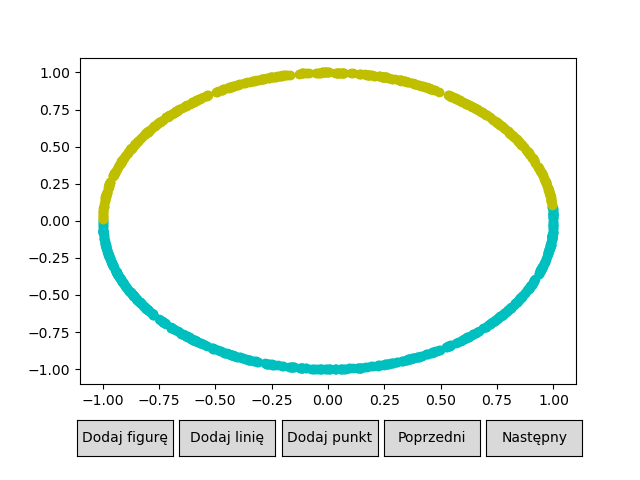

In [97]:
%matplotlib notebook

def draw_classification_result(points: list, classification: list[PointType]):
    divided_points_ids = divide_into_groups(points, classification)
    divided_points = {
        PointType.RIGHT: [points[i] for i in divided_points_ids[PointType.RIGHT]],
        PointType.LEFT: [points[i] for i in divided_points_ids[PointType.LEFT]],
        PointType.COLLINEAR: [points[i] for i in divided_points_ids[PointType.COLLINEAR]],
    }

    # for i, point in enumerate(points):
    #     divided_points[classification[i]].append(point)

    left_point_collection = PointsCollection(points=divided_points[PointType.LEFT], color='c')
    right_point_collection = PointsCollection(points=divided_points[PointType.RIGHT], color='y')
    collinear_point_collection = PointsCollection(points=divided_points[PointType.COLLINEAR], color='m')

    plot = Plot(points=[left_point_collection, right_point_collection, collinear_point_collection])
    plot.draw()


dataset_to_draw = '1c'
method_to_draw = 'BB'

draw_classification_result(datasets_points[dataset_to_draw], points_classifications[dataset_to_draw][method_to_draw])


In [21]:
# time checking

import time

classifications_times = {class_code: [] for class_code in classifications}

dataset_name = '1d'

methods = [('AA', create_3x3_matrix, calc_det), ('BA', create_3x3_matrix, np.linalg.det), ('AB', create_2x2_matrix, calc_det), ('BB', create_2x2_matrix, np.linalg.det)]

for code, size, det in methods*10:
    start = time.perf_counter_ns()
    classify_points(datasets_points[dataset_name], classification_vector, size, det)
    end = time.perf_counter_ns()
    classifications_times[code].append(end - start)

for code, results in classifications_times.items():
    print(code, results)

for code, results in classifications_times.items():
    print(code, sum(results)/len(results))

AA [60232241, 18643519, 17719794, 18020742, 17678518, 17110216, 17002870, 16938057, 17291106, 17164903]
AB [8077322, 6161776, 6104297, 5880664, 5833241, 5774085, 5797622, 5670789, 5564351, 5810194]
BA [19559491, 10758750, 9754079, 10519473, 9895927, 10245834, 9739203, 10302895, 10282919, 10108944]
BB [10983850, 9765882, 9182495, 9281950, 8996158, 9192553, 9005168, 9367575, 8859967, 9450547]
AA 21780196.6
AB 6067434.1
BA 11116751.5
BB 9408614.5
